In [18]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from tqdm import tqdm
from torch.nn import Dropout
from numpy import argmax
from numpy import vstack
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, recall_score



In [19]:

# # 
# Load the dataset
df = pd.read_csv('C:/Users/HP/Desktop/S3/Deep Learning/lab2/predictive_maintenance.csv')

# Select only numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Replace NaN values with the mean of the respective columns (numeric only)
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Encode categorical variables ('Product ID' and 'Type') using one-hot encoding
df = pd.get_dummies(df, columns=['Product ID', 'Type'])

# Label encode the 'Failure Type' column
label_encoder = LabelEncoder()
df['Failure Type'] = label_encoder.fit_transform(df['Failure Type'])

# Normalize numerical features to a specific range (e.g., 0 to 1)
numeric_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
scaler = MinMaxScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])
#Display the preprocessed DataFrame
#print(df)

In [20]:
# Dataset definition
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, dataframe):
        # store the inputs and outputs
        self.X = dataframe.drop(['Target', 'Failure Type'], axis=1).values.astype('float32')
        self.y = dataframe['Failure Type'].values.astype('int64')  # Assuming Failure Type is integer-encoded
#         self.y = LabelEncoder().fit_transform(self.y)

    # number of rows in the dataset
    def __len__(self):
        return len(self.X)

    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

    # get indexes for train and test rows
    def get_splits(self, test_size=0.33):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=test_size, random_state=42)
        train = CSVDataset(pd.DataFrame(data=X_train, columns=df.columns[:-2], dtype='float32'))
        test = CSVDataset(pd.DataFrame(data=X_test, columns=df.columns[:-2], dtype='float32'))
        return train, test


In [21]:
print(df.describe())

               UDI  Air temperature [K]  Process temperature [K]   
count  10000.00000         10000.000000             10000.000000  \
mean    5000.50000             0.511405                 0.531551   
std     2886.89568             0.217419                 0.183177   
min        1.00000             0.000000                 0.000000   
25%     2500.75000             0.326087                 0.382716   
50%     5000.50000             0.521739                 0.543210   
75%     7500.25000             0.673913                 0.666667   
max    10000.00000             1.000000                 1.000000   

       Rotational speed [rpm]   Torque [Nm]  Tool wear [min]        Target   
count            10000.000000  10000.000000     10000.000000  10000.000000  \
mean                 0.215818      0.497073         0.426684      0.033900   
std                  0.104356      0.136936         0.251597      0.180981   
min                  0.000000      0.000000         0.000000      0.000000 

In [22]:
# print(df.info())

In [23]:
# Histogrammes des variables numériques
#df[numeric_features].hist(bins=20, figsize=(12, 8))
#plt.show()

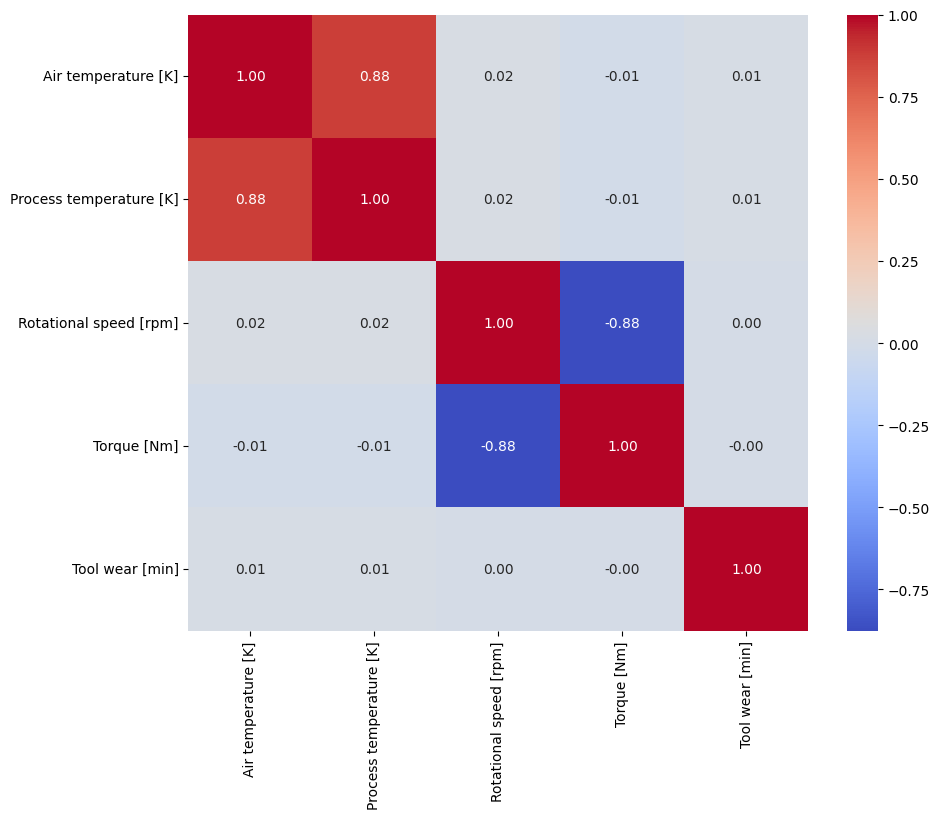

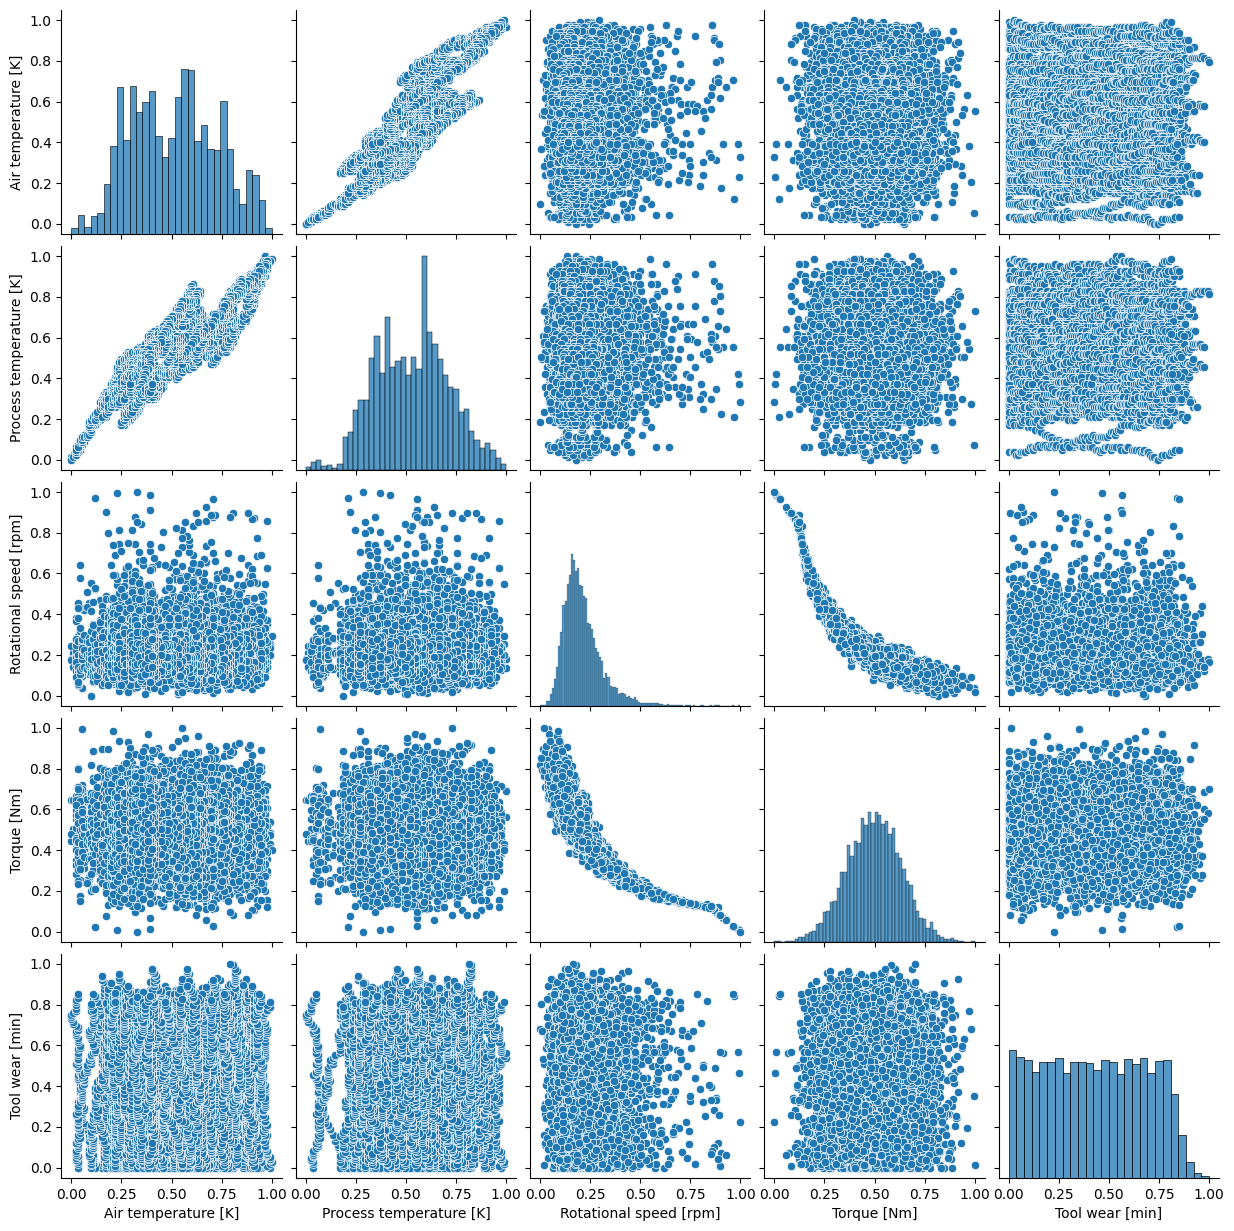

In [24]:
correlation_matrix = df[numeric_features].corr()

# Heatmap de la matrice de corrélation

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

# Diagrammes de dispersion pour quelques paires de variables
sns.pairplot(df[numeric_features])
#plt.show()

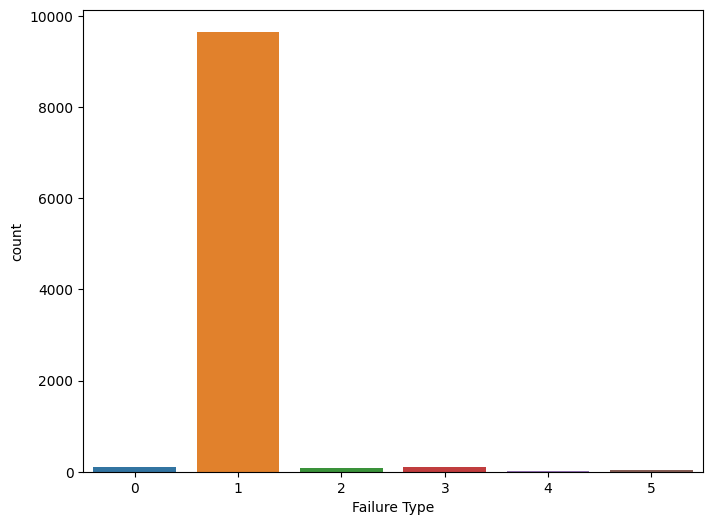

In [25]:
# Diagramme à barres pour la variable cible
plt.figure(figsize=(8, 6))
sns.countplot(x='Failure Type', data=df)
plt.show()


In [26]:
# DNN
# model 
class MLP(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, 10)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.dropout1 = Dropout(0.2)
        # second hidden layer
        self.hidden2 = Linear(10, 8)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # third hidden layer and output
        self.hidden3 = Linear(8, 3)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Softmax(dim=1)

    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.dropout1(X) 
        # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # output layer
        X = self.hidden3(X)
        X = self.act3(X)
        return X

In [27]:
# prepare the dataset
def prepare_data(df):


    # Instantiate the dataset
    dataset = CSVDataset(df)

    # Split the dataset into train and test
    train, test = dataset.get_splits()

    # Create DataLoader for training and testing
    train_loader = DataLoader(train, batch_size=512, shuffle=True)
    test_loader = DataLoader(test, batch_size=512, shuffle=False)
    return train_loader, test_loader

In [28]:
number_epochs = 100 
learning_rate = 0.1
loss_per_epoch = []
loss_per_epoch_validation= []

# #####
# accuracy_per_epoch = []
# accuracy_per_epoch_validation = []
# #####
# train the model
def train_model(train_loader, model):
    size = len(train_loader.dataset)
    # define loss function MSE 
    criterion = CrossEntropyLoss()
    # define the optimization ADAM 
    # regularization L2 = weight_decay #
    optimizer =  Adam(model.parameters(), lr=learning_rate, weight_decay= 0.1 )
    epoch = 0 

    # enumerate epochs
    #while(average_loss >= desired_error): # accroding to loss function do epochs 
    for epoch in tqdm(range(number_epochs),desc='Training Epochs'):
        print(f"Epoch {epoch+1}\n-------------------------------") # enumerate mini batches
        # training data 
        total_loss = 0.0
        model.train()
        TrainigStep_loss = []
        for batch, (inputs, targets) in enumerate(train_loader):
            
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            #print("y befor" , inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
            TrainigStep_loss.append(loss.item())
            #total_loss += loss.item()
        
        #average_loss = total_loss / len(train_loader)
        loss = np.array(TrainigStep_loss).mean()
        loss_per_epoch.append(loss)
        print(f"loss: {loss:>7f}")
        #print(f"Average loss :{average_loss:>7f}" )
        
        # test / validation data 
        model.eval()     # Optional when not using Model Specific layer
        validationStep_loss = []
        for batch, (inputs, targets) in enumerate(test_loader):
            
            # Forward Pass
            outputs = model(inputs)
            # Find the Loss
            validation_loss = criterion(outputs, targets)
            # Calculate Loss
            validationStep_loss.append(validation_loss.item())
            
        loss_per_epoch_validation.append(np.array(validationStep_loss).mean())
        
        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(TrainigStep_loss)
        valid_loss = np.average(validationStep_loss)
                # Inside the training loop
#         # ...
#         train_accuracy = evaluate_model(train_loader, model)
#         validation_accuracy = evaluate_model(test_loader, model)
#         accuracy_per_epoch.append(train_accuracy)
#         accuracy_per_epoch_validation.append(validation_accuracy)
#         # ...
       
     
        


In [29]:
# evaluate the model
def evaluate_model(test_loader, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_loader):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        # convert to class labels
        yhat = argmax(yhat, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
#     predictions, actuals = vstack(predictions), vstack(actuals)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    f1 = f1_score(actuals, predictions, average='weighted')
    sensitivity = recall_score(actuals, predictions, average='weighted')
    return acc, f1, sensitivity
# , f1

In [30]:
# prepare the data
# df = pd.read_csv('C:/Users/HP/Desktop/S3/Deep Learning/lab2/predictive_maintenance.csv')
train_loader, test_loader = prepare_data(df)
print(len(train_loader.dataset), len(test_loader.dataset))
# # define the network
# model = MLP(5)
# Modifier le modèle en fonction du nombre de caractéristiques dans votre ensemble de données
num_features = len(train_loader.dataset[0][0])
model = MLP(num_features)

# train the model
train_model(train_loader, model)



6700 3300


Training Epochs:   0%|                                                                         | 0/100 [00:00<?, ?it/s]

Epoch 1
-------------------------------


Training Epochs:   1%|▋                                                                | 1/100 [00:00<00:41,  2.39it/s]

loss: 1.545321
Epoch 2
-------------------------------


Training Epochs:   2%|█▎                                                               | 2/100 [00:00<00:35,  2.74it/s]

loss: 0.774049
Epoch 3
-------------------------------


Training Epochs:   3%|█▉                                                               | 3/100 [00:01<00:33,  2.90it/s]

loss: 0.555714
Epoch 4
-------------------------------


Training Epochs:   4%|██▌                                                              | 4/100 [00:01<00:32,  2.98it/s]

loss: 0.555092
Epoch 5
-------------------------------


Training Epochs:   5%|███▎                                                             | 5/100 [00:01<00:31,  2.99it/s]

loss: 0.556730
Epoch 6
-------------------------------


Training Epochs:   6%|███▉                                                             | 6/100 [00:02<00:31,  2.97it/s]

loss: 0.555711
Epoch 7
-------------------------------


Training Epochs:   7%|████▌                                                            | 7/100 [00:02<00:31,  2.97it/s]

loss: 0.557513
Epoch 8
-------------------------------


Training Epochs:   8%|█████▏                                                           | 8/100 [00:02<00:30,  3.01it/s]

loss: 0.556305
Epoch 9
-------------------------------


Training Epochs:   9%|█████▊                                                           | 9/100 [00:03<00:30,  3.03it/s]

loss: 0.555706
Epoch 10
-------------------------------


Training Epochs:  10%|██████▍                                                         | 10/100 [00:03<00:29,  3.05it/s]

loss: 0.556725
Epoch 11
-------------------------------


Training Epochs:  11%|███████                                                         | 11/100 [00:03<00:29,  3.06it/s]

loss: 0.557190
Epoch 12
-------------------------------


Training Epochs:  12%|███████▋                                                        | 12/100 [00:04<00:28,  3.10it/s]

loss: 0.556179
Epoch 13
-------------------------------


Training Epochs:  13%|████████▎                                                       | 13/100 [00:04<00:28,  3.07it/s]

loss: 0.556398
Epoch 14
-------------------------------


Training Epochs:  14%|████████▉                                                       | 14/100 [00:04<00:27,  3.09it/s]

loss: 0.555895
Epoch 15
-------------------------------


Training Epochs:  15%|█████████▌                                                      | 15/100 [00:05<00:29,  2.90it/s]

loss: 0.556269
Epoch 16
-------------------------------


Training Epochs:  16%|██████████▏                                                     | 16/100 [00:05<00:30,  2.78it/s]

loss: 0.556170
Epoch 17
-------------------------------


Training Epochs:  17%|██████████▉                                                     | 17/100 [00:05<00:29,  2.85it/s]

loss: 0.555906
Epoch 18
-------------------------------


Training Epochs:  18%|███████████▌                                                    | 18/100 [00:06<00:28,  2.84it/s]

loss: 0.556831
Epoch 19
-------------------------------


Training Epochs:  19%|████████████▏                                                   | 19/100 [00:06<00:28,  2.89it/s]

loss: 0.556123
Epoch 20
-------------------------------


Training Epochs:  20%|████████████▊                                                   | 20/100 [00:06<00:27,  2.91it/s]

loss: 0.556908
Epoch 21
-------------------------------


Training Epochs:  21%|█████████████▍                                                  | 21/100 [00:07<00:27,  2.91it/s]

loss: 0.557355
Epoch 22
-------------------------------


Training Epochs:  22%|██████████████                                                  | 22/100 [00:07<00:26,  2.95it/s]

loss: 0.556668
Epoch 23
-------------------------------


Training Epochs:  23%|██████████████▋                                                 | 23/100 [00:07<00:26,  2.91it/s]

loss: 0.555815
Epoch 24
-------------------------------


Training Epochs:  24%|███████████████▎                                                | 24/100 [00:08<00:26,  2.86it/s]

loss: 0.556590
Epoch 25
-------------------------------


Training Epochs:  25%|████████████████                                                | 25/100 [00:08<00:26,  2.84it/s]

loss: 0.556097
Epoch 26
-------------------------------


Training Epochs:  26%|████████████████▋                                               | 26/100 [00:08<00:25,  2.86it/s]

loss: 0.556182
Epoch 27
-------------------------------


Training Epochs:  27%|█████████████████▎                                              | 27/100 [00:09<00:25,  2.87it/s]

loss: 0.557196
Epoch 28
-------------------------------


Training Epochs:  28%|█████████████████▉                                              | 28/100 [00:09<00:25,  2.81it/s]

loss: 0.556224
Epoch 29
-------------------------------


Training Epochs:  29%|██████████████████▌                                             | 29/100 [00:09<00:25,  2.80it/s]

loss: 0.556909
Epoch 30
-------------------------------


Training Epochs:  30%|███████████████████▏                                            | 30/100 [00:10<00:26,  2.69it/s]

loss: 0.556023
Epoch 31
-------------------------------


Training Epochs:  31%|███████████████████▊                                            | 31/100 [00:10<00:26,  2.62it/s]

loss: 0.557263
Epoch 32
-------------------------------


Training Epochs:  32%|████████████████████▍                                           | 32/100 [00:11<00:24,  2.75it/s]

loss: 0.555663
Epoch 33
-------------------------------


Training Epochs:  33%|█████████████████████                                           | 33/100 [00:11<00:23,  2.82it/s]

loss: 0.556428
Epoch 34
-------------------------------


Training Epochs:  34%|█████████████████████▊                                          | 34/100 [00:11<00:22,  2.88it/s]

loss: 0.556372
Epoch 35
-------------------------------


Training Epochs:  35%|██████████████████████▍                                         | 35/100 [00:12<00:21,  2.96it/s]

loss: 0.556776
Epoch 36
-------------------------------


Training Epochs:  36%|███████████████████████                                         | 36/100 [00:12<00:21,  2.92it/s]

loss: 0.556000
Epoch 37
-------------------------------


Training Epochs:  37%|███████████████████████▋                                        | 37/100 [00:12<00:21,  2.91it/s]

loss: 0.556946
Epoch 38
-------------------------------


Training Epochs:  38%|████████████████████████▎                                       | 38/100 [00:13<00:21,  2.88it/s]

loss: 0.556122
Epoch 39
-------------------------------


Training Epochs:  39%|████████████████████████▉                                       | 39/100 [00:13<00:20,  2.91it/s]

loss: 0.556857
Epoch 40
-------------------------------


Training Epochs:  40%|█████████████████████████▌                                      | 40/100 [00:13<00:20,  2.87it/s]

loss: 0.556411
Epoch 41
-------------------------------


Training Epochs:  41%|██████████████████████████▏                                     | 41/100 [00:14<00:22,  2.68it/s]

loss: 0.556513
Epoch 42
-------------------------------


Training Epochs:  42%|██████████████████████████▉                                     | 42/100 [00:14<00:20,  2.78it/s]

loss: 0.556174
Epoch 43
-------------------------------


Training Epochs:  43%|███████████████████████████▌                                    | 43/100 [00:14<00:20,  2.83it/s]

loss: 0.556993
Epoch 44
-------------------------------


Training Epochs:  44%|████████████████████████████▏                                   | 44/100 [00:15<00:21,  2.65it/s]

loss: 0.555748
Epoch 45
-------------------------------


Training Epochs:  45%|████████████████████████████▊                                   | 45/100 [00:15<00:20,  2.68it/s]

loss: 0.556646
Epoch 46
-------------------------------


Training Epochs:  46%|█████████████████████████████▍                                  | 46/100 [00:16<00:19,  2.79it/s]

loss: 0.556497
Epoch 47
-------------------------------


Training Epochs:  47%|██████████████████████████████                                  | 47/100 [00:16<00:19,  2.74it/s]

loss: 0.556230
Epoch 48
-------------------------------


Training Epochs:  48%|██████████████████████████████▋                                 | 48/100 [00:16<00:19,  2.71it/s]

loss: 0.556471
Epoch 49
-------------------------------


Training Epochs:  49%|███████████████████████████████▎                                | 49/100 [00:17<00:19,  2.61it/s]

loss: 0.556482
Epoch 50
-------------------------------


Training Epochs:  50%|████████████████████████████████                                | 50/100 [00:17<00:18,  2.68it/s]

loss: 0.556293
Epoch 51
-------------------------------


Training Epochs:  51%|████████████████████████████████▋                               | 51/100 [00:17<00:17,  2.76it/s]

loss: 0.557052
Epoch 52
-------------------------------


Training Epochs:  52%|█████████████████████████████████▎                              | 52/100 [00:18<00:18,  2.55it/s]

loss: 0.556364
Epoch 53
-------------------------------


Training Epochs:  53%|█████████████████████████████████▉                              | 53/100 [00:18<00:18,  2.50it/s]

loss: 0.555653
Epoch 54
-------------------------------


Training Epochs:  54%|██████████████████████████████████▌                             | 54/100 [00:19<00:18,  2.51it/s]

loss: 0.556824
Epoch 55
-------------------------------


Training Epochs:  55%|███████████████████████████████████▏                            | 55/100 [00:19<00:19,  2.35it/s]

loss: 0.556340
Epoch 56
-------------------------------


Training Epochs:  56%|███████████████████████████████████▊                            | 56/100 [00:20<00:18,  2.40it/s]

loss: 0.556607
Epoch 57
-------------------------------


Training Epochs:  57%|████████████████████████████████████▍                           | 57/100 [00:20<00:17,  2.44it/s]

loss: 0.555666
Epoch 58
-------------------------------


Training Epochs:  58%|█████████████████████████████████████                           | 58/100 [00:20<00:17,  2.44it/s]

loss: 0.557649
Epoch 59
-------------------------------


Training Epochs:  59%|█████████████████████████████████████▊                          | 59/100 [00:21<00:17,  2.31it/s]

loss: 0.555635
Epoch 60
-------------------------------


Training Epochs:  60%|██████████████████████████████████████▍                         | 60/100 [00:21<00:17,  2.28it/s]

loss: 0.556953
Epoch 61
-------------------------------


Training Epochs:  61%|███████████████████████████████████████                         | 61/100 [00:22<00:16,  2.33it/s]

loss: 0.556164
Epoch 62
-------------------------------


Training Epochs:  62%|███████████████████████████████████████▋                        | 62/100 [00:22<00:15,  2.42it/s]

loss: 0.556380
Epoch 63
-------------------------------


Training Epochs:  63%|████████████████████████████████████████▎                       | 63/100 [00:22<00:15,  2.46it/s]

loss: 0.556262
Epoch 64
-------------------------------


Training Epochs:  64%|████████████████████████████████████████▉                       | 64/100 [00:23<00:14,  2.57it/s]

loss: 0.556200
Epoch 65
-------------------------------


Training Epochs:  65%|█████████████████████████████████████████▌                      | 65/100 [00:23<00:13,  2.64it/s]

loss: 0.556284
Epoch 66
-------------------------------


Training Epochs:  66%|██████████████████████████████████████████▏                     | 66/100 [00:24<00:12,  2.73it/s]

loss: 0.556474
Epoch 67
-------------------------------


Training Epochs:  67%|██████████████████████████████████████████▉                     | 67/100 [00:24<00:12,  2.64it/s]

loss: 0.556028
Epoch 68
-------------------------------


Training Epochs:  68%|███████████████████████████████████████████▌                    | 68/100 [00:24<00:11,  2.68it/s]

loss: 0.556120
Epoch 69
-------------------------------


Training Epochs:  69%|████████████████████████████████████████████▏                   | 69/100 [00:25<00:11,  2.81it/s]

loss: 0.557092
Epoch 70
-------------------------------


Training Epochs:  70%|████████████████████████████████████████████▊                   | 70/100 [00:25<00:10,  2.92it/s]

loss: 0.555521
Epoch 71
-------------------------------


Training Epochs:  71%|█████████████████████████████████████████████▍                  | 71/100 [00:25<00:09,  2.96it/s]

loss: 0.557624
Epoch 72
-------------------------------


Training Epochs:  72%|██████████████████████████████████████████████                  | 72/100 [00:26<00:09,  2.97it/s]

loss: 0.555958
Epoch 73
-------------------------------


Training Epochs:  73%|██████████████████████████████████████████████▋                 | 73/100 [00:26<00:09,  2.70it/s]

loss: 0.556761
Epoch 74
-------------------------------


Training Epochs:  74%|███████████████████████████████████████████████▎                | 74/100 [00:26<00:09,  2.78it/s]

loss: 0.555875
Epoch 75
-------------------------------


Training Epochs:  75%|████████████████████████████████████████████████                | 75/100 [00:27<00:08,  2.85it/s]

loss: 0.556523
Epoch 76
-------------------------------


Training Epochs:  76%|████████████████████████████████████████████████▋               | 76/100 [00:27<00:08,  2.89it/s]

loss: 0.556145
Epoch 77
-------------------------------


Training Epochs:  77%|█████████████████████████████████████████████████▎              | 77/100 [00:27<00:08,  2.85it/s]

loss: 0.556283
Epoch 78
-------------------------------


Training Epochs:  78%|█████████████████████████████████████████████████▉              | 78/100 [00:28<00:07,  2.90it/s]

loss: 0.556027
Epoch 79
-------------------------------


Training Epochs:  79%|██████████████████████████████████████████████████▌             | 79/100 [00:28<00:07,  2.77it/s]

loss: 0.557664
Epoch 80
-------------------------------


Training Epochs:  80%|███████████████████████████████████████████████████▏            | 80/100 [00:28<00:07,  2.84it/s]

loss: 0.556041
Epoch 81
-------------------------------


Training Epochs:  81%|███████████████████████████████████████████████████▊            | 81/100 [00:29<00:06,  2.88it/s]

loss: 0.556262
Epoch 82
-------------------------------


Training Epochs:  82%|████████████████████████████████████████████████████▍           | 82/100 [00:29<00:06,  2.89it/s]

loss: 0.556344
Epoch 83
-------------------------------


Training Epochs:  83%|█████████████████████████████████████████████████████           | 83/100 [00:29<00:05,  2.93it/s]

loss: 0.556348
Epoch 84
-------------------------------


Training Epochs:  84%|█████████████████████████████████████████████████████▊          | 84/100 [00:30<00:05,  2.91it/s]

loss: 0.556139
Epoch 85
-------------------------------


Training Epochs:  85%|██████████████████████████████████████████████████████▍         | 85/100 [00:30<00:05,  2.93it/s]

loss: 0.556865
Epoch 86
-------------------------------


Training Epochs:  86%|███████████████████████████████████████████████████████         | 86/100 [00:31<00:05,  2.78it/s]

loss: 0.555733
Epoch 87
-------------------------------


Training Epochs:  87%|███████████████████████████████████████████████████████▋        | 87/100 [00:31<00:04,  2.86it/s]

loss: 0.556791
Epoch 88
-------------------------------


Training Epochs:  88%|████████████████████████████████████████████████████████▎       | 88/100 [00:31<00:04,  2.75it/s]

loss: 0.555944
Epoch 89
-------------------------------


Training Epochs:  89%|████████████████████████████████████████████████████████▉       | 89/100 [00:32<00:04,  2.71it/s]

loss: 0.556142
Epoch 90
-------------------------------


Training Epochs:  90%|█████████████████████████████████████████████████████████▌      | 90/100 [00:32<00:03,  2.76it/s]

loss: 0.557239
Epoch 91
-------------------------------


Training Epochs:  91%|██████████████████████████████████████████████████████████▏     | 91/100 [00:32<00:03,  2.64it/s]

loss: 0.555541
Epoch 92
-------------------------------


Training Epochs:  92%|██████████████████████████████████████████████████████████▉     | 92/100 [00:33<00:02,  2.70it/s]

loss: 0.557074
Epoch 93
-------------------------------


Training Epochs:  93%|███████████████████████████████████████████████████████████▌    | 93/100 [00:33<00:02,  2.74it/s]

loss: 0.555816
Epoch 94
-------------------------------


Training Epochs:  94%|████████████████████████████████████████████████████████████▏   | 94/100 [00:34<00:02,  2.71it/s]

loss: 0.556578
Epoch 95
-------------------------------


Training Epochs:  95%|████████████████████████████████████████████████████████████▊   | 95/100 [00:34<00:01,  2.69it/s]

loss: 0.555977
Epoch 96
-------------------------------


Training Epochs:  96%|█████████████████████████████████████████████████████████████▍  | 96/100 [00:34<00:01,  2.73it/s]

loss: 0.556351
Epoch 97
-------------------------------


Training Epochs:  97%|██████████████████████████████████████████████████████████████  | 97/100 [00:35<00:01,  2.80it/s]

loss: 0.556310
Epoch 98
-------------------------------


Training Epochs:  98%|██████████████████████████████████████████████████████████████▋ | 98/100 [00:35<00:00,  2.73it/s]

loss: 0.556440
Epoch 99
-------------------------------


Training Epochs:  99%|███████████████████████████████████████████████████████████████▎| 99/100 [00:35<00:00,  2.79it/s]

loss: 0.555471
Epoch 100
-------------------------------


Training Epochs: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.77it/s]

loss: 0.557021


In [31]:
import plotly.graph_objects as go

# Assuming you have loss_per_epoch and loss_per_epoch_validation lists
#loss_per_epoch = [0.5, 0.4, 0.3]  # Replace with your actual list
#loss_per_epoch_validation = [0.6, 0.5, 0.4]  # Replace with your actual list

# Create the figure
fig = go.Figure()

# Add training loss trace
fig.add_trace(go.Scatter(x=list(range(len(loss_per_epoch))),
                         y=loss_per_epoch,
                         mode='lines',
                         name='train'))

# Add validation loss trace
fig.add_trace(go.Scatter(x=list(range(len(loss_per_epoch_validation))),
                         y=loss_per_epoch_validation,
                         mode='lines',
                         name='test'))

# Add labels and title
fig.update_layout(title='model loss',
                  xaxis=dict(title='epoch'),
                  yaxis=dict(title='loss'))

# Show the figure
fig.show()
#fig.write_image("LOSS_DNN_(30,20,10,1).svg")

In [32]:
# evaluate the model on the test set
acc_test, f1_test, sensitivity_test = evaluate_model(test_loader, model)
print(f'Test Accuracy: {acc_test:.3f}, Test F1 Score: {f1_test:.3f}, Test Sensitivity: {sensitivity_test:.3f}')

# evaluate the model on the training set
acc_train, f1_train, sensitivity_train = evaluate_model(train_loader, model)
print(f'Training Accuracy: {acc_train:.3f}, Training F1 Score: {f1_train:.3f}, Training Sensitivity: {sensitivity_train:.3f}')


Test Accuracy: 1.000, Test F1 Score: 1.000, Test Sensitivity: 1.000
Training Accuracy: 1.000, Training F1 Score: 1.000, Training Sensitivity: 1.000


In [33]:
# make a class prediction for one row of data
def predict(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return yhat


In [34]:
# # make a single prediction
# row = [0.5, 0.3, 0.4, 0.2, 0.1, 0.1, 0.3, 0.4, 0.2, 0.1]
# yhat = predict(row, model)
# print('Predicted: %s (class=%d)' % (yhat, argmax(yhat)))